# Fertile Egg Detector [CH2-PS266]

Bangkit Batch 2 2023

**Designing a Deep Learning-Based Mobile Application for Egg Candling**

*Theme: Food Accessibility, Agribusiness, and Food Security*

**Team Member**

1.  (ML) M466BSX1032 – Brilian Herda – Universitas Sains Al-Qur’ an - [Active]
2.  (ML) M466BSY1195 – Ahmad Ma'ruf – Universitas Sains Al-Qur’an - [Active]
3.  (ML) M123BSY1353 – Habibi Ahmadi Muslim – Politeknik Elektronika Negeri Surabaya - [Active]
4.  (CC) C182BSY3830 – Fathin Cahyo Ramadhan – Universitas Amikom Purwokerto - [Active]
5.  (CC) C182BSY3969 – Yuntafa Ulkhaq – Universitas Amikom Purwokerto - [Active]
6.  (MD) A182BSY2566 – Sandhya Nugraha Qusnur Aulia - Universitas Amikom Purwokerto - [Active]
7.  (MD) A548BKY4459 - Zulfahmi M. Ardianto - UIN Sunan Kalijaga Yogyakarta - [Active]

In this project, we've leveraged a cloud-based machine learning model for egg classification. This model, trained on diverse egg stage data, enables real-time analysis of images from the camera or gallery within the mobile app. It accurately categorizes eggs into early, mid, late, or non-viable stages, enhancing its functionality significantly.


In [1]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 973.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 24.2 MB/s eta 0:00:00


In [2]:
# Import lib
import zipfile
import os

import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt


# There is bug in tensorflowjs. see: https://github.com/google/jax/issues/18978. cant import tensorflowjs, so cant convert to tfjs
# import tensorflowjs as tfjs

import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


• Using TensorFlow Version: 2.15.0
• Using TensorFlow Hub Version:  0.15.0
• GPU Device Found.


In [3]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [4]:
# PARSING CSV LABEL
# Btw, label didalamnya tuh kek gini:

# ' Pertengahan',
# ' Tahap Akhir',
# ' Tahap Awal',
# ' Telur Mati',

# Ada spasinya gitu, tapi ga masalah sih, cuma ngingetin aja
# kalo ada bug, bisa jadi karena labelnya ini

import zipfile
import os
import pandas as pd

# Extract the archive
# ini file zip-nya di upload ke colab. biar simple aja. kalo mau pake drive ya sangat-sangat recomended.

local_zip = '/content/egg-condition-classifications.v2i.multiclass (with test).zip'
# local_zip = '/content/egg-condition-classifications.v2i.multiclass.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data/')
zip_ref.close()

# Assign training and validation set directories
base_dir = '/content/data'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Load the labels
train_labels = pd.read_csv("/content/data/train/_classes.csv")
valid_labels = pd.read_csv("/content/data/valid/_classes.csv")
test_labels = pd.read_csv("/content/data/test/_classes.csv")

#parsing train_labels
train_labels['combined_label'] = train_labels.apply(
    lambda row: 'Pertengahan' if row[' Pertengahan'] == 1  else (
        'Tahap_akhir' if row[' Tahap Akhir'] == 1 else (
            'Tahap_awal' if row[' Tahap Awal'] == 1 else 'Telur_mati'
        )
    ),
    axis=1
)
#parsing valid_labels
valid_labels['combined_label'] = valid_labels.apply(
    lambda row: 'Pertengahan' if row[' Pertengahan'] == 1  else (
        'Tahap_akhir' if row[' Tahap Akhir'] == 1 else (
            'Tahap_awal' if row[' Tahap Awal'] == 1 else 'Telur_mati'
        )
    ),
    axis=1
)
#parsing test_labels
test_labels['combined_label'] = test_labels.apply(
    lambda row: 'Pertengahan' if row[' Pertengahan'] == 1  else (
        'Tahap_akhir' if row[' Tahap Akhir'] == 1 else (
            'Tahap_awal' if row[' Tahap Awal'] == 1 else 'Telur_mati'
        )
    ),
    axis=1
)

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# PREPROCESSING BANGGG

BATCH_SIZE = 13

training_datagen = ImageDataGenerator(
	  rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
) # with augmentation

valid_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_dataframe(
    train_labels,
    directory=train_dir,
    x_col="filename",  # nama kolom yang berisi nama gambar pada csv train.
    y_col="combined_label",  # nama kolom yang berisi label pada csv train.
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=len(train_labels) // 52
)#.prefetch(tf.keras.data.experimental.AUTOTUNE)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_labels,
    directory=valid_dir,
    x_col="filename",  # nama kolom yang berisi nama gambar pada csv valid.
    y_col="combined_label",  # nama kolom yang berisi label pada csv valid.
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=len(valid_labels) // 20
)#.prefetch(tf.keras.data.experimental.AUTOTUNE)

test_generator = test_datagen.flow_from_dataframe(
    test_labels,
    directory=test_dir,
    x_col="filename",  # nama kolom yang berisi nama gambar pada csv train.
    y_col="combined_label",  # nama kolom yang berisi label pada csv train.
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=1
)

Found 429 validated image filenames belonging to 4 classes.
Found 165 validated image filenames belonging to 4 classes.
Found 68 validated image filenames belonging to 4 classes.


In [6]:
# Convert Datagen (FrameIterator) to tf.data.Dataset for Atribut .take()

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE,224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, 4), dtype=tf.float32) # 4 for num of class
    )
)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: valid_generator,
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE,224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, 4), dtype=tf.float32) # 4 for num of class
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_signature=(
        tf.TensorSpec(shape=(1,224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(1, 4), dtype=tf.float32) # 4 for num of class
    )
)



In [7]:
# Take one batch from the dataset
for image_batch, label_batch in train_dataset.take(1):
    pass

# Now you can use image_batch and label_batch as NumPy arrays
image_batch.shape

TensorShape([13, 224, 224, 3])

In [16]:
# Defining the Model
# All it takes is to put a linear classifier
# on top of the feature_extractor_layer with the Hub module.

# For speed, i start out with a non-trainable feature_extractor_layer,
# but you can also enable fine-tuning for greater accuracy.

do_fine_tuning = True

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 2915908 (11.12 MB)
Trainable params: 2881796 (10.99 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [17]:
# Optional Unfreeze some layers
NUM_LAYERS = 1 # min 1, max 50

if do_fine_tuning:
    feature_extractor.trainable = True

    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

In [18]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check the loss
    if(logs.get('val_accuracy') > 0.90 and logs.get('accuracy') > 0.976 ):

      # Stop if threshold is met
      print("\n val_acc > 90 & acc > 97. stop training")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()


lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    min_lr=1e-6
)

In [19]:
# TRAINING

if do_fine_tuning:
    model.compile(
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

steps_per_epoch = train_generator.n
validation_steps = valid_generator.n

EPOCHS = 200
hist = model.fit(train_generator,
                 epochs=EPOCHS,
                 validation_data=valid_generator,
                 steps_per_epoch=steps_per_epoch // 13,
                 verbose=2,
                 validation_steps=validation_steps // 13,
                 callbacks=[callbacks, lr_callback])

Epoch 1/200
33/33 - 80s - loss: 1.2828 - accuracy: 0.4452 - val_loss: 1.3820 - val_accuracy: 0.3654 - lr: 0.0010 - 80s/epoch - 2s/step
Epoch 2/200
33/33 - 9s - loss: 0.9596 - accuracy: 0.7319 - val_loss: 1.1569 - val_accuracy: 0.5705 - lr: 0.0010 - 9s/epoch - 284ms/step
Epoch 3/200
33/33 - 10s - loss: 0.8095 - accuracy: 0.7879 - val_loss: 0.9850 - val_accuracy: 0.7115 - lr: 0.0010 - 10s/epoch - 298ms/step
Epoch 4/200
33/33 - 8s - loss: 0.7124 - accuracy: 0.7995 - val_loss: 0.8751 - val_accuracy: 0.7372 - lr: 0.0010 - 8s/epoch - 244ms/step
Epoch 5/200
33/33 - 8s - loss: 0.6513 - accuracy: 0.8135 - val_loss: 0.7292 - val_accuracy: 0.7692 - lr: 0.0010 - 8s/epoch - 244ms/step
Epoch 6/200
33/33 - 9s - loss: 0.5192 - accuracy: 0.8858 - val_loss: 0.6164 - val_accuracy: 0.8526 - lr: 0.0010 - 9s/epoch - 266ms/step
Epoch 7/200
33/33 - 8s - loss: 0.4889 - accuracy: 0.8998 - val_loss: 0.5958 - val_accuracy: 0.8654 - lr: 0.0010 - 8s/epoch - 241ms/step
Epoch 8/200
33/33 - 9s - loss: 0.4593 - accurac

# Visualization

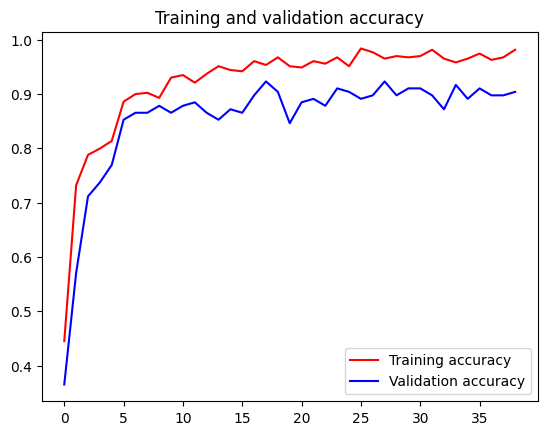

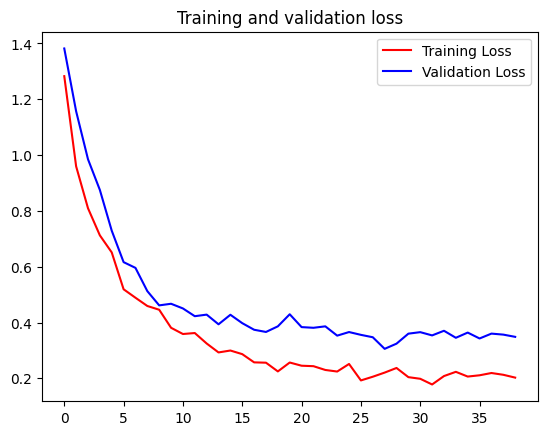

In [20]:
# Plot the results
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Export/Save Model

In [21]:
EGG_CANDLING_SAVED_MODEL = "exp_saved_model/1"

tf.saved_model.save(model, EGG_CANDLING_SAVED_MODEL)

In [22]:
# convert ke zip

# Nama folder yang berisi hasil konversi TensorFlow.js
folder_model = 'exp_saved_model'

# Fungsi untuk membuat file zip dari folder hasil konversi
def create_zip_file(folder_name):
    with zipfile.ZipFile('exp_saved_model.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_name):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_name))

# Panggil fungsi untuk membuat file zip
create_zip_file(folder_model)

try:
    from google.colab import files
    files.download('exp_saved_model.zip')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Convert to TFLite

In [24]:
# INI KALO MAU CONVERT KE TFLITE
converter = tf.lite.TFLiteConverter.from_saved_model(EGG_CANDLING_SAVED_MODEL)



# Post-Training Quantization
# ----------------------------
# The simplest form of post-training quantization quantizes weights
# from floating point to 8-bits of precision.
# This technique is enabled as an option in the TensorFlow Lite converter.
# At inference, weights are converted from 8-bits of precision to floating point
# and computed using floating-point kernels. This conversion is done once
# and cached to reduce latency.

# To further improve latency, hybrid operators dynamically quantize activations
# to 8-bits and perform computations with 8-bit weights and activations.
# This optimization provides latencies close to fully fixed-point inference.
# However, the outputs are still stored using floating point,
# so that the speedup with hybrid ops is less than a full fixed-point computation.

converter.optimizations = [tf.lite.Optimize.DEFAULT]


# Post-Training Integer Quantization
# ----------------------------
# We can get further latency improvements, reductions in peak memory usage,
# and access to integer only hardware accelerators
# by making sure all model math is quantized. To do this,
# we need to measure the dynamic range of activations and inputs
# with a representative data set. You can simply create an input data generator
# and provide it to our converter.

def representative_data_gen():
    for input_value, _ in test_dataset.take(67):
        yield [input_value]

converter.representative_dataset = representative_data_gen

# The resulting model will be fully quantized but still take float input and output for convenience.

# Ops that do not have quantized implementations will automatically be left in floating point.
# This allows conversion to occur smoothly but may restrict deployment to accelerators that support float.


# Full Integer Quantization
# ----------------------------
# To require the converter to only output integer operations, one can specify:

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]


# FINALLY CONVERT THE MODEL
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)


In [25]:
# KALO MAU DOWNLOAD HASIL CONVERT DI COLLAB
try:
    from google.colab import files
    files.download('converted_model.tflite')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Convert to TFJS

In [ ]:
# Convert the SavedModel to TensorFlow.js format
tfjs.converters.convert_tf_saved_model(EGG_CANDLING_SAVED_MODEL, 'tfjs_model')

In [ ]:
# convert ke zip

# Nama folder yang berisi hasil konversi TensorFlow.js
folder_model = 'tfjs_model'

# Fungsi untuk membuat file zip dari folder hasil konversi
def create_zip_file(folder_name):
    with zipfile.ZipFile('tfjs_model.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_name):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_name))

# Panggil fungsi untuk membuat file zip
create_zip_file(folder_model)

In [ ]:
# KALO MAU DOWNLOAD HASIL CONVERT DI COLLAB
try:
    from google.colab import files
    files.download('tfjs_model.zip')
except:
    pass

# Test TFlite Model

100it [00:02, 39.90it/s]


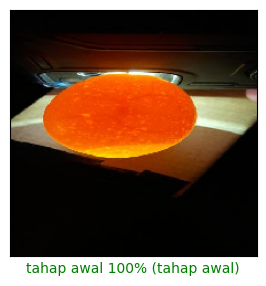

In [26]:
# TEST HASIL CONVERT KE TFLITE

# Load TFLite model and allocate tensors.

interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_dataset.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))

    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


# Utility functions for plotting
# Utilities for plotting

class_names = ['pertengahan', 'akhir', 'tahap awal', 'telur mati']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], np.argmax(true_label[i]), img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)


# Visualize the outputs { run: "auto" }
index = 61
plt.figure(figsize=(7,6))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()


In [ ]:
# while True:pass